# Trees in Pittsburgh
In this notebook, we take a look at the **thousands** of trees throughout the city to determine the best neighborhood.

Trees are such a valuable resource to any community. They provide shade, block noise, have been shown to reduce stress and frankly just look nice. I don't think anyone could argue that trees are a bad thing and in fact, there are some more concrete, quantitative evidence that adding trees to a neighborhood is beneficial as we will explore in this notebook.

In [1]:
# All Required Imports
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas

In [81]:
# Original Database. Way to many collumns that I don't need
full_trees = pd.read_csv("https://data.wprdc.org/datastore/dump/1515a93c-73e3-4425-9b35-1cd11b2196da")
# Shortened database I will be using
trees = full_trees[['common_name', 'height','condition','neighborhood','air_quality_benfits_total_dollar_value']].copy()
trees.head(10)


/opt/tljh/user/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,common_name,height,condition,neighborhood,air_quality_benfits_total_dollar_value
0,Stump,0.0,NaN,Homewood North,NaN
1,Linden: Littleleaf,0.0,NaN,Oakwood,11.457438
2,Maple: Red,22.0,Fair,South Side Flats,2.474653
3,Maple: Freeman,25.0,Fair,East Allegheny,3.865612
4,Maple: Norway,52.0,Good,Highland Park,25.638395
5,Oak: Pin,45.0,Good,Highland Park,15.696870
6,Dogwood: Corneliancherry,8.0,Good,Highland Park,0.682080
7,Maple: Norway,27.0,Good,Highland Park,8.501194
8,Maple: Norway,35.0,Good,Highland Park,12.244539
9,Maple: Norway,NaN,Poor,Stanton Heights,NaN


## The DataSet:
I am using the [number of trees dataset](https://data.wprdc.org/dataset/city-trees) from the WPRDC. The raw CSV contains nearly 50 columns most of which are irrelevant to my search for the best neighborhood. In the code above, I imported the csv and then created a new dataset with just the columns I need.

*Keep in mind that this data set only looks at trees maintained by the city so neighborhoods could have additional trees that arent officially counted.*

In [82]:
print("There are " + str(len(trees)) + " trees managed by the City of Pittsburgh")
trees.describe()


There are 45709 trees managed by the City of Pittsburgh


,height,air_quality_benfits_total_dollar_value
count,41335.000000,40044.000000
mean,22.162235,7.370215
std,17.568577,7.382228
min,0.000000,0.000000
25%,9.000000,1.544349
50%,20.000000,4.862005
75%,35.000000,10.985833
max,158.000000,42.873431


## Trees are Important!
Looking at the overall description of the data, the impact of trees is clearly seen. In total, all the trees in Pittsburgh are offsetting negative air quality by over **forty thousand dollars**. 

Unfortunately, the source doesn't give a very specific description on what that dollar value means but no one can argue it is a bad thing. Note that the average dollar benefit per tree is 7 This means that the more trees in a neighborhood the more it is benefiting the air. 

In the next code block we will find which neighborhood has the most trees per acre and as such will be the best neighborhood. 

In [83]:
# This takes in neighborhood dataset from wprdc
acres = pd.read_csv("https://data.wprdc.org/datastore/dump/668d7238-cfd2-492e-b397-51a6e74182ff")
acres = acres [['hood', 'acres']] #This shrinks dataframe so we just have a neighborhood ('hood') --> acres correlation

# This shrinks the trees data set and then counts the occurances of each neighborhood to get trees per neighborhood
trees_per_neighborhood = full_trees [['neighborhood', 'id']] # neighborhood --> id correlation
trees_per_neighborhood = trees_per_neighborhood.rename({'id':'number_of_trees'}, axis = 1)
trees_per_neighborhood = trees_per_neighborhood.groupby('neighborhood').count()


#merges the acres data set with the trees_per_neighborhood for future caluculation
trees_per_acre_per_neighborhood = trees_per_neighborhood.merge(acres, how='inner', left_on='neighborhood',
                                                              right_on = 'hood')
trees_per_acre_per_neighborhood = trees_per_acre_per_neighborhood[['hood','number_of_trees','acres']]
trees_per_acre_per_neighborhood = trees_per_acre_per_neighborhood.rename({'hood':'neighborhood'}, axis=1)

#for some reason perry North (row 60) has 0 acres in the dataset so I manually found it on wikipedia
trees_per_acre_per_neighborhood.at[60, 'acres'] = 775.68  


# adds new colum wich divides num of trees by acres to get trees per acre (the final metric for this calculation)
trees_per_acre_per_neighborhood['trees_per_acre'] = trees_per_acre_per_neighborhood['number_of_trees'] / trees_per_acre_per_neighborhood['acres']
trees_per_acre_per_neighborhood = trees_per_acre_per_neighborhood.sort_values(by = 'trees_per_acre', ascending = False)


trees_per_acre_per_neighborhood.head(10)

,neighborhood,number_of_trees,acres,trees_per_acre
0,Allegheny Center,867,134.703,6.436382
33,Friendship,362,68.297,5.300379
1,Allegheny West,386,90.841,4.249183
18,Central Northside,674,166.475,4.048656
48,Manchester,707,179.566,3.937271
39,Highland Park,2941,747.691,3.933443
28,East Liberty,1366,373.650,3.655828
65,Regent Square,434,123.682,3.508999
23,Crawford-Roberts,568,166.101,3.419606
49,Marshall-Shadeland,488,148.209,3.292648


In [84]:
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile
trees_map = neighborhoods.merge(trees_per_acre_per_neighborhood, how='left', left_on='hood', 
                               right_on= 'neighborhood')


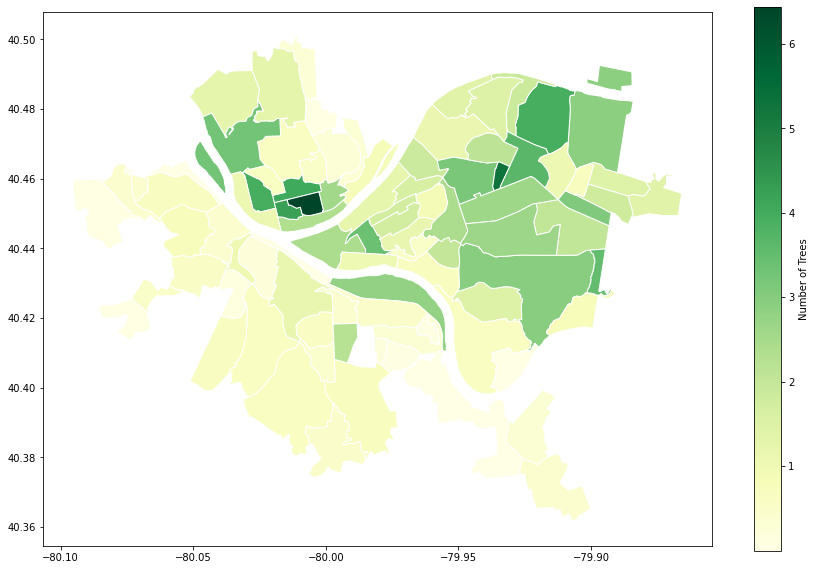

In [85]:
trees_map.plot(column = 'trees_per_acre',
               cmap = 'YlGn',
               edgecolor='white',
               legend=True,
               legend_kwds={'label' : "Number of Trees"},
               figsize=(15, 10))

## Analysis
The table clearly shows that Allegheny Center contains the most trees given its size. In general, the neighborhood containing parks tend to have a much higher number of trees which intuitively makes sense. This is not an unfair comparison since I would argue that parks are a huge resource to any community and if a certain neighborhood has a lot of them then they have a lot of trees. Thus, the greatest number of trees would be the best neighborhood.In this case, that would be Allegheny Center. However, there are a couple other datasets to consider when choosing the "greenest" neighborhood which may take away Allegheny Center's lead.